# Task
Our task is simple, recognize handwritten digits. We will use MNIST dataset for this tutorial.


# Import necessary library
In this tutorial, we are going to use pytorch, the cutting-edge deep learning framework to complete our task.

In [1]:
import torch
import torchvision

In [2]:
## Create dataloader, in PyTorch, we feed the trainer data with use of dataloader
## We create dataloader with dataset from torchvision,
## and we dont have to download it seperately, all automatically done

# Define batch size, batch size is how much data you feed for training in one iteration
batch_size_train = 64 # We use a small batch size here for training
batch_size_test = 1024 #

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
#image datasets
train_dataset = torchvision.datasets.MNIST('dataset/',
                                           train=True,
                                           download=True,
                                           transform=image_transform)
test_dataset = torchvision.datasets.MNIST('dataset/',
                                          train=False,
                                          download=True,
                                          transform=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test,
                                          shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 57.7MB/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.77MB/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.1MB/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.66MB/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



Label: tensor(3)


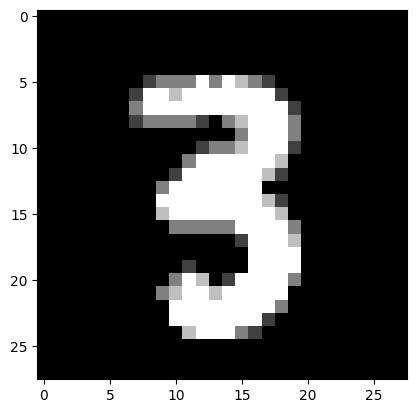

In [3]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(test_loader))
sample = example_datas[0][0]
# show the data
plt.imshow(sample, cmap='gray', interpolation='none')
print("Label: "+ str(labels[0]))

In [4]:
## Now we can start to build our CNN model
## We first import the pytorch nn module and optimizer
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
## Then define the model class
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #input channel 1, output channel 10
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1)
        #input channel 10, output channel 20
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1)
        #dropout layer
        self.conv2_drop = nn.Dropout2d()
        #fully connected layer
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.view(-1, 320)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x)

In [5]:
## create model and optimizer
learning_rate = 0.01
momentum = 0.95
device = "cpu"
model = CNN().to(device) #using cpu here
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

In [6]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer, epoch, log_interval=10000):
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    counter = 0
    for batch_idx, (data, target) in enumerate(tk0):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        counter += 1
        tk0.set_postfix(loss=(loss.item()*data.size(0) / (counter * train_loader.batch_size)))
##define test function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [7]:
num_epoch = 3
for epoch in range(1, num_epoch + 1):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)

<ipython-input-6-db2a97642a49>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk0 = tqdm(train_loader, total=int(len(train_loader)))


  0%|          | 0/938 [00:00<?, ?it/s]

<ipython-input-4-12098198c1fe>:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Average loss: 0.1794, Accuracy: 9473/10000 (95%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1349, Accuracy: 9592/10000 (96%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1301, Accuracy: 9610/10000 (96%)



In [8]:
from torchsummary import summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


<ipython-input-4-12098198c1fe>:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
